<a href="https://colab.research.google.com/github/Koo82/ML/blob/main/h_35_%E1%84%89%E1%85%B5%E1%84%8F%E1%85%AF%E1%86%AB%E1%84%89%E1%85%B3%E1%84%91%E1%85%A2%E1%84%90%E1%85%A5%E1%86%AB%E1%84%87%E1%85%AE%E1%86%AB%E1%84%85%E1%85%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰 센서 데이터로 분류

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as snㅡㄴ2ㅇㅇs
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

In [34]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone_human.txt.zip\
    -o smartphone_human.txt.zip
# !curl -L https://bit.ly/36LsyVs -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.5M  100 10.5M    0     0  39.7M      0 --:--:-- --:--:-- --:--:-- 39.7M


In [35]:
!unzip -o smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
  inflating: __MACOSX/._smartphone_human.txt  


In [36]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [37]:
!head -5 smartphone_human.txt

# sampling 주기 50ms

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [38]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)

In [39]:
df[:2]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [41]:
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].apply(np.float)
df.dropna(axis=0, how='any', inplace=True)

In [42]:
p='1234'
type(np.float(p))

float

In [43]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


In [44]:
df.isnull().sum()

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

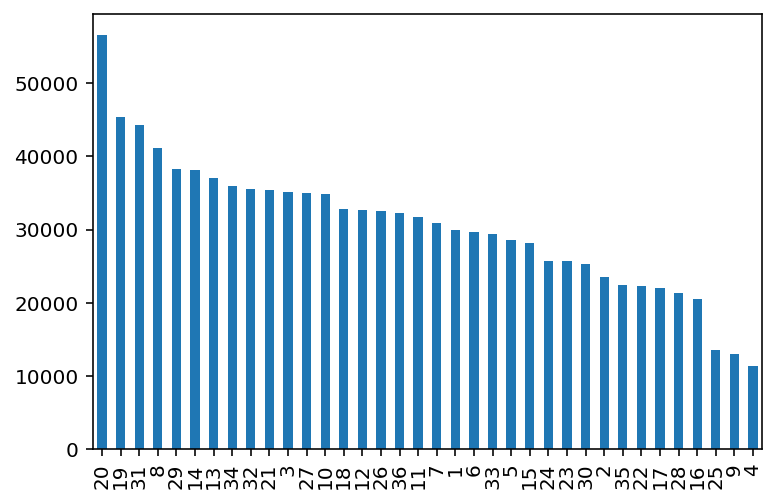

In [45]:
df['user-id'].value_counts().plot(kind='bar')

In [46]:
df["user-id"].nunique()

36

In [47]:
sorted(df["user-id"].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36]

In [48]:
                        df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


In [49]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

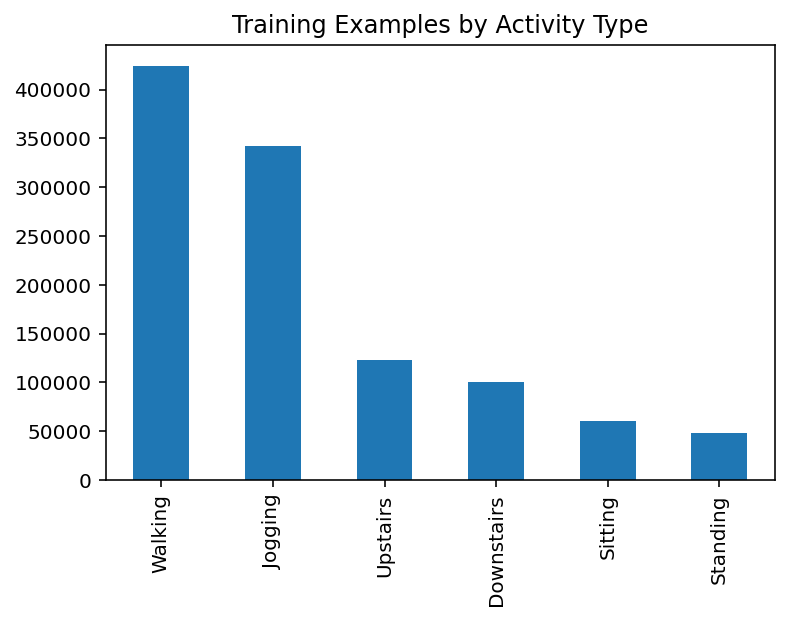

In [50]:
# plt.figure(dpi=200)
df['activity'].value_counts().plot(kind='bar',
    title='Training Examples by Activity Type')
plt.show()

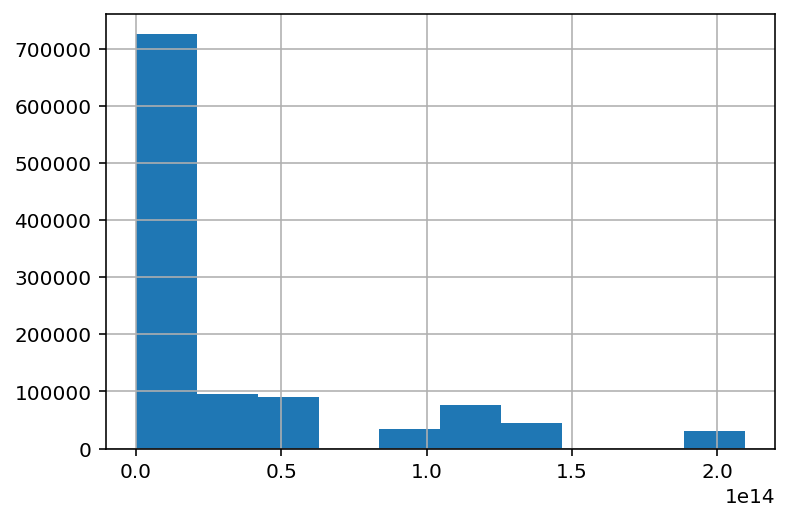

In [51]:
df['timestamp'].hist()

In [52]:
(df['timestamp'] == 0).sum()

12843

In [53]:
# 시각이 0이거나 음수인 샘플은 제외
# 제외하지 않은 경우와 비교
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

In [54]:
np.unique(df['activity'])

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

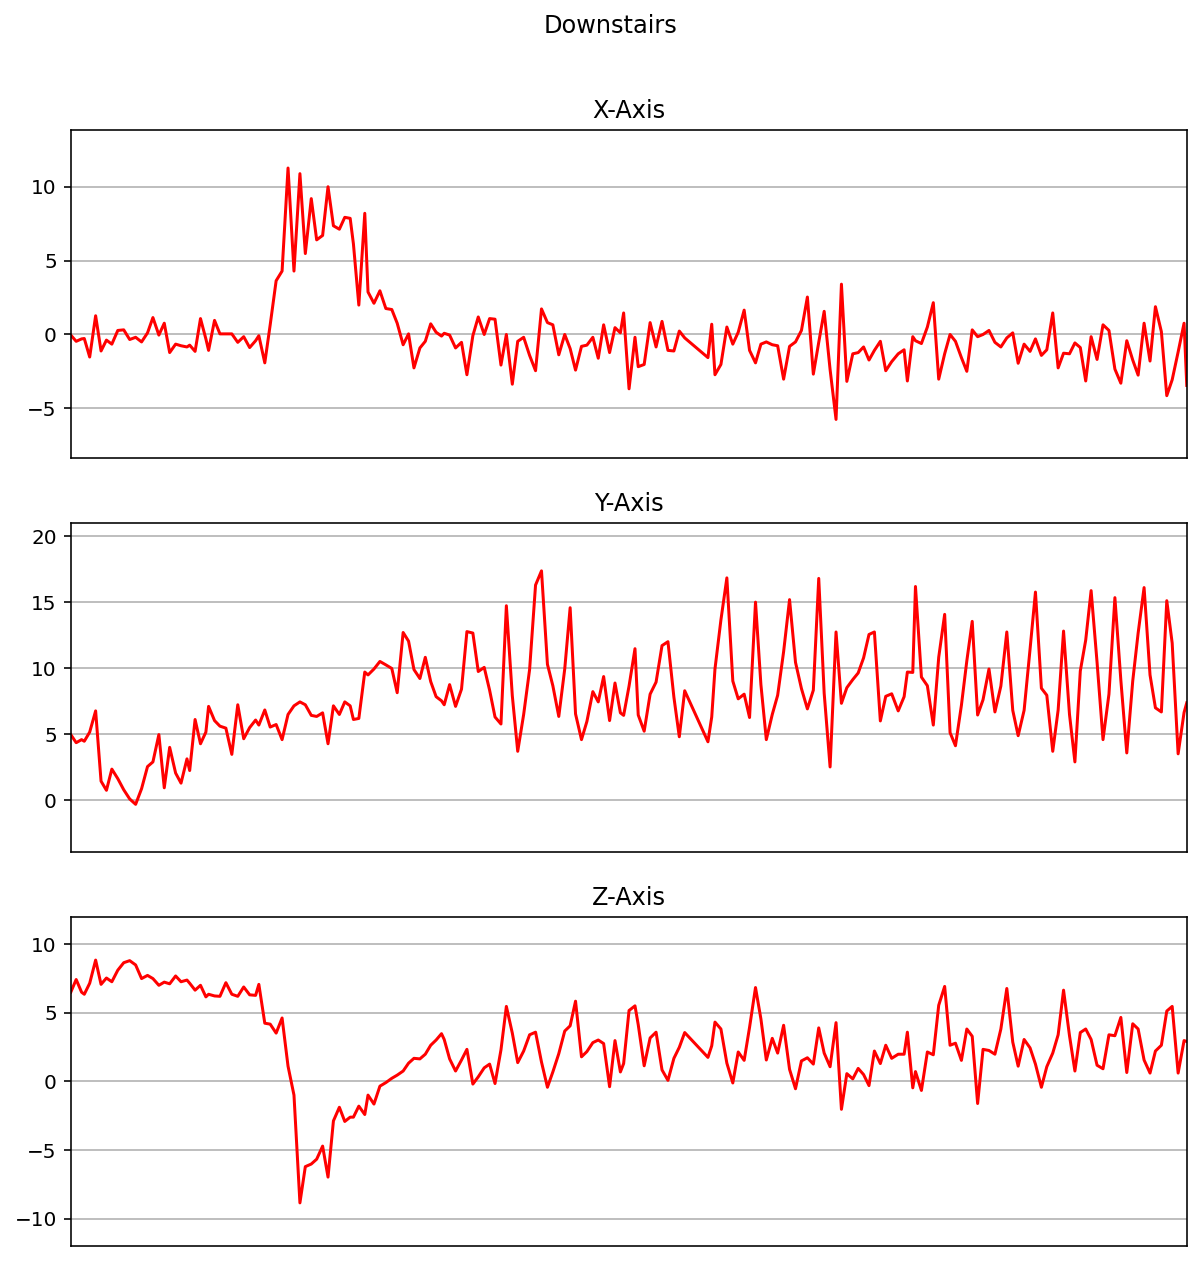

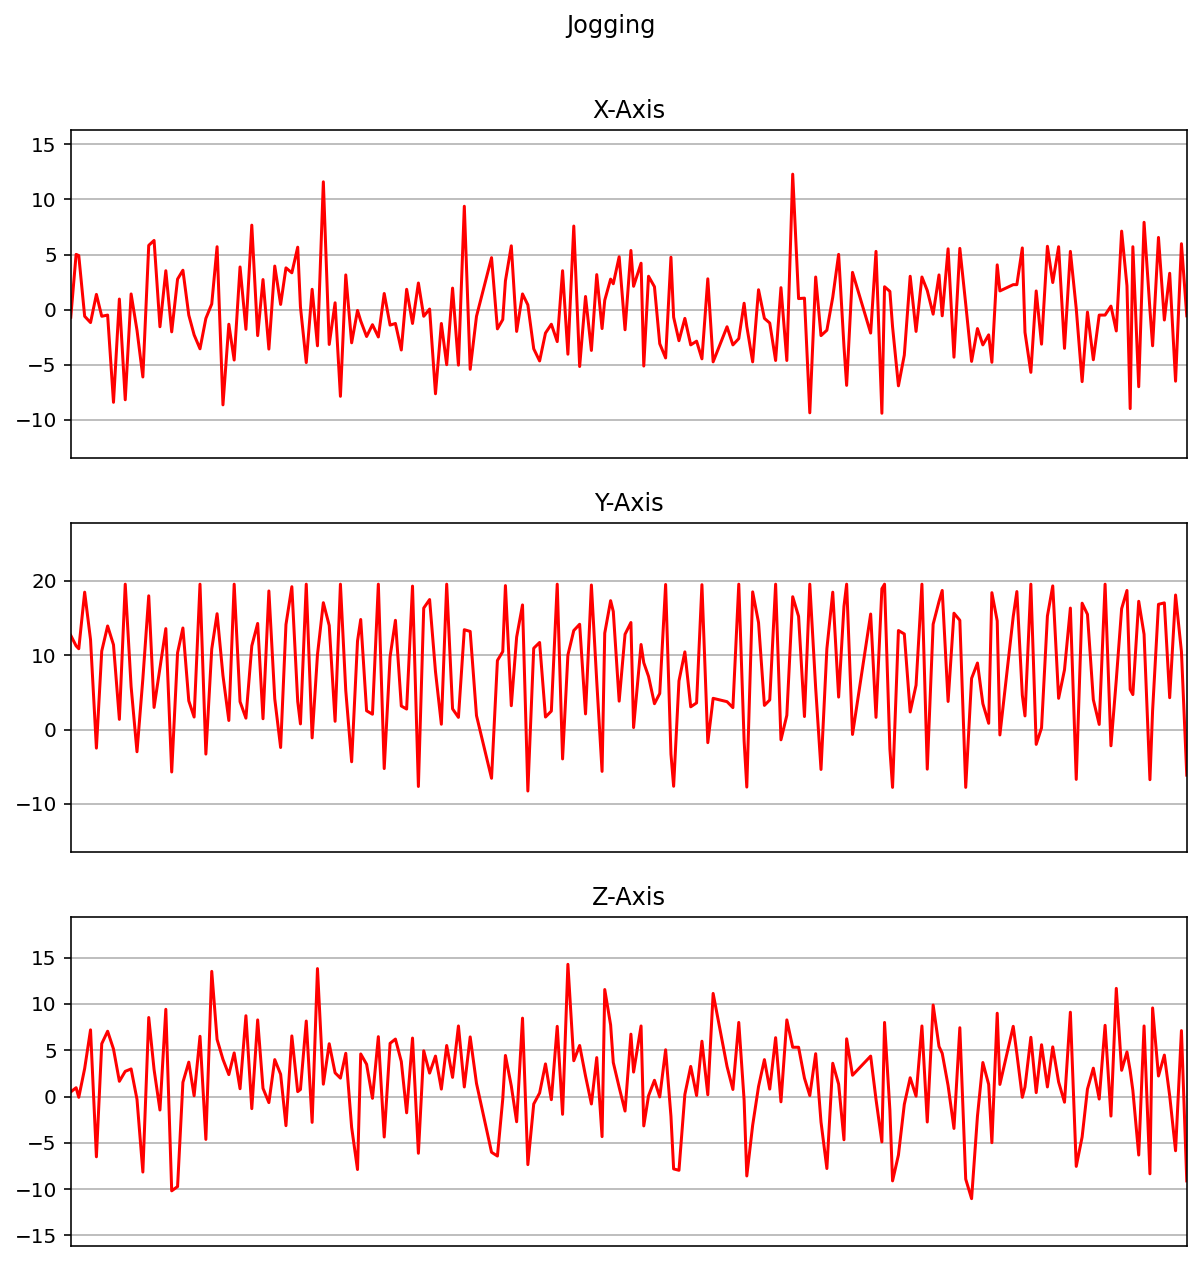

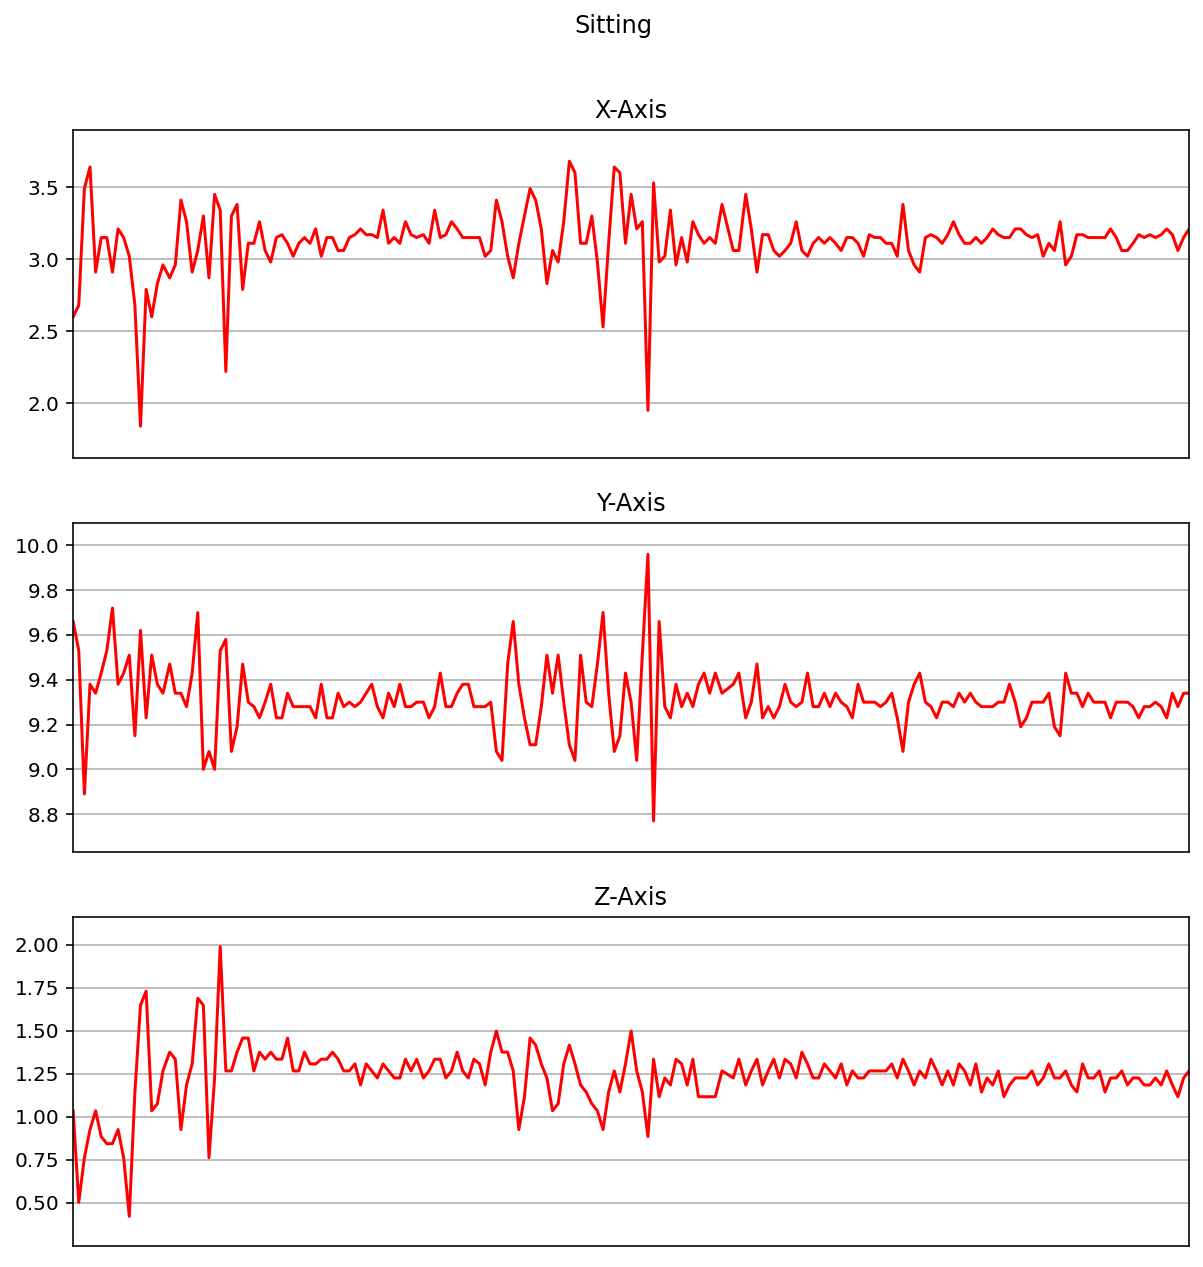

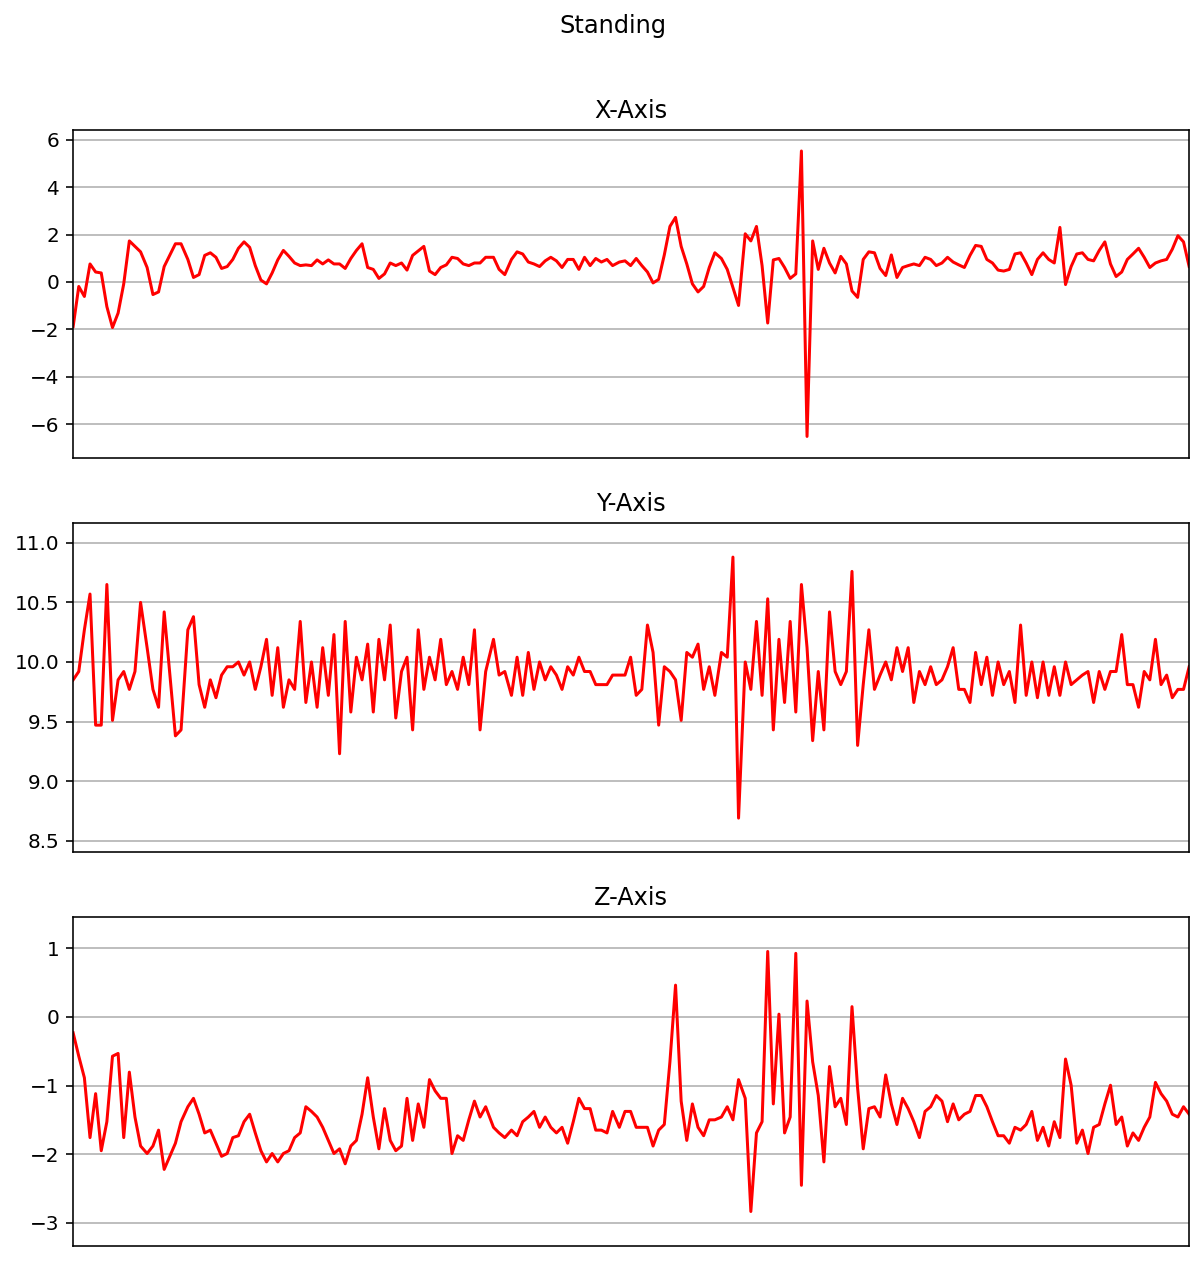

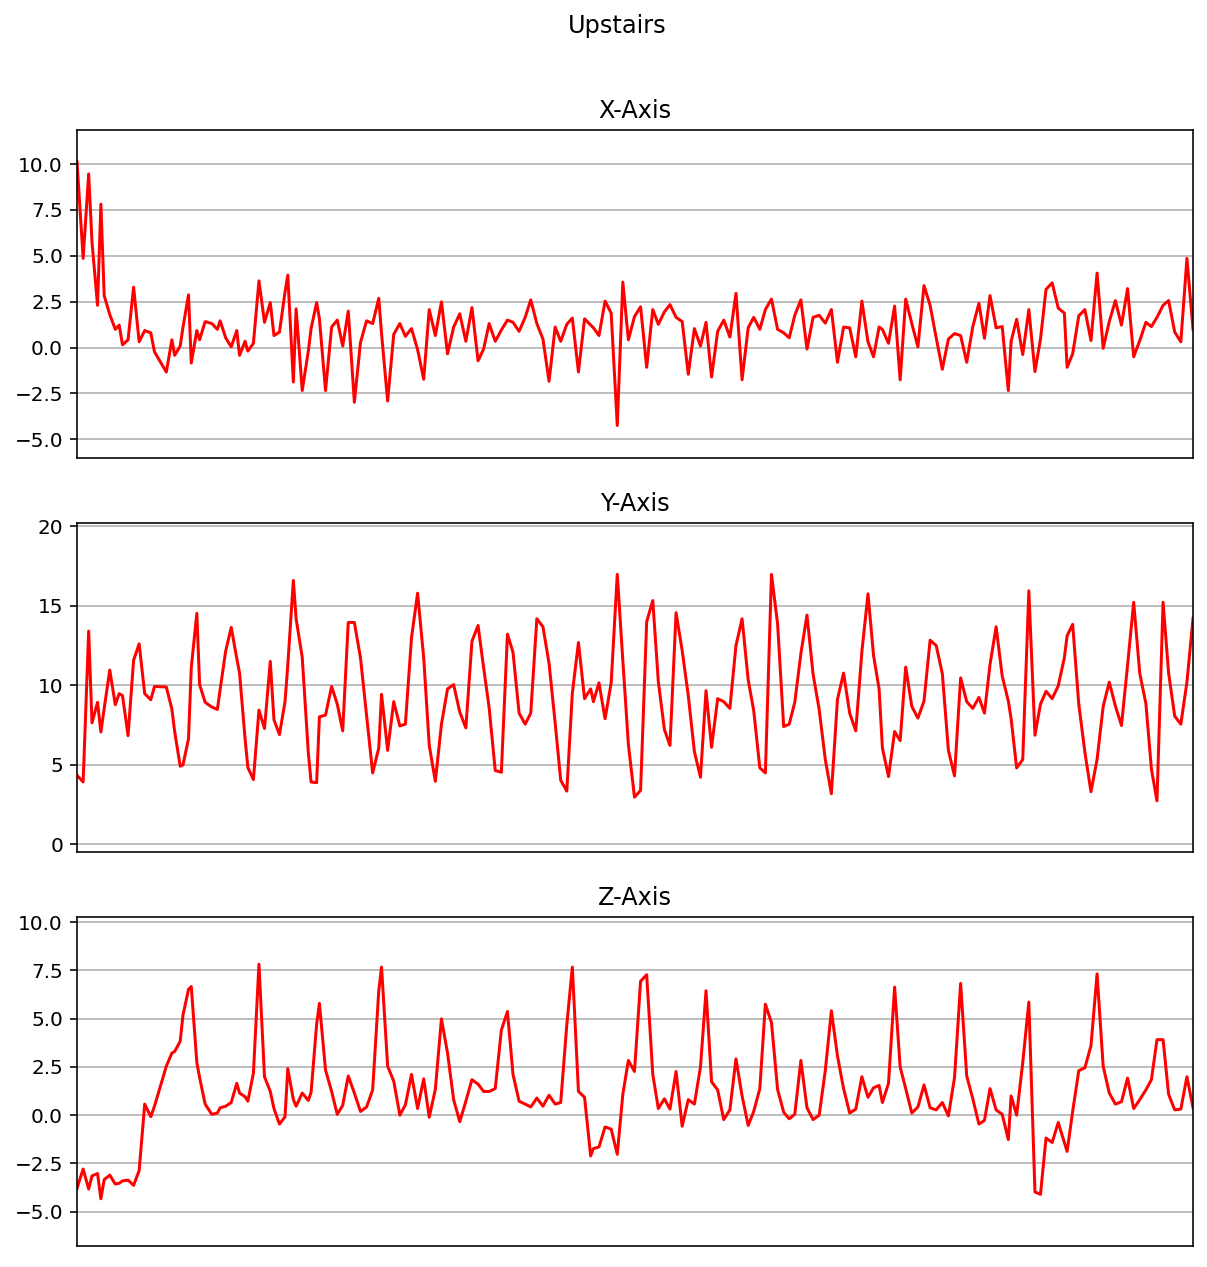

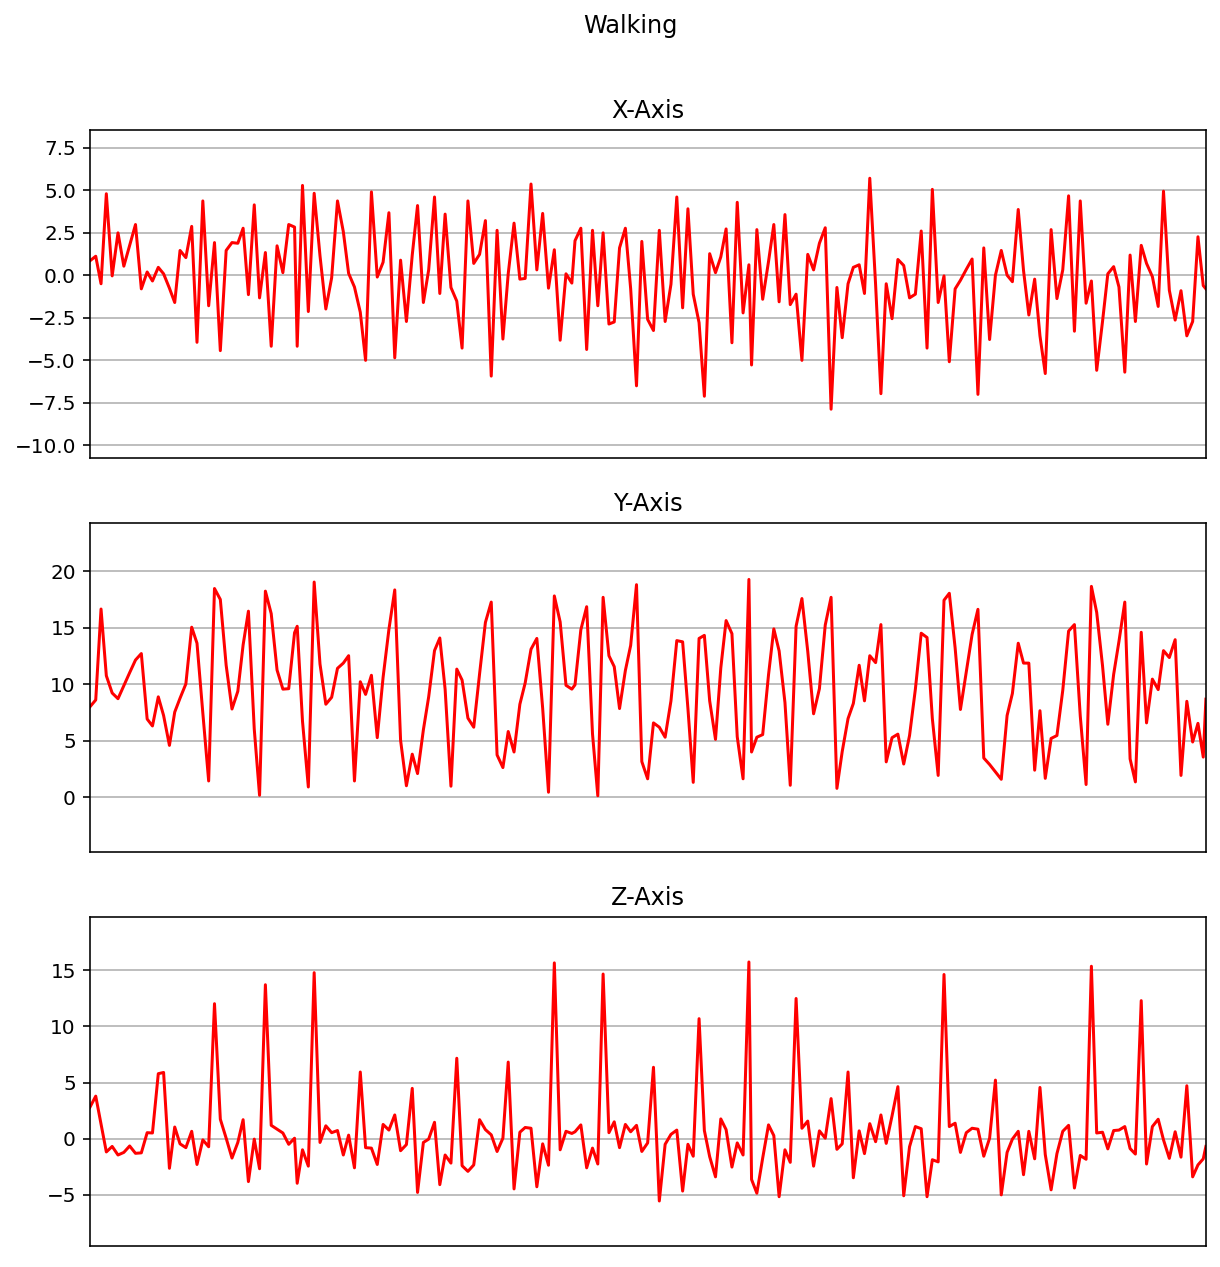

In [55]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

In [56]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [57]:
le.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [58]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1


In [59]:
test = [3,3,3,4,4,4,4,4]
m = stats.mode(test) # 최빈값
m

ModeResult(mode=array([4]), count=array([5]))

In [60]:
m[1][0]

5

In [61]:
m[0][0], m[1][0]

(4, 5)

In [62]:
z = stats.mode(df['act'][10000:10100]) # 5초간 관찰
z[0][0], z[1][0]

(5, 100)

In [63]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [64]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


## 훈련 데이터 검증 데이터 나누기
- (1안) 사람별로 데이터를 구분하는 방법
- (2안) 같은 사람의 데이터를 훈련/검증용으로 나누어 사용하는 방안

In [65]:
(df['user-id'] < 28).mean()

0.7410978845728606

In [66]:
(df['user-id'] >= 28).mean()

0.25890211542713937

In [67]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]
# 랜덤하게 추출하는 것이 원칙

In [68]:
df["z-axis"].isnull().sum()

0

In [69]:
df.isnull()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1098199,False,False,False,False,False,False,False
1098200,False,False,False,False,False,False,False
1098201,False,False,False,False,False,False,False
1098202,False,False,False,False,False,False,False


In [70]:
# split_seq 유사한 작업

def get_xy(N, df): # N  윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append([xs, ys, zs])
            y.append(action)
    return np.transpose(X, (0,2,1)), np.array(y)

In [71]:
# - 데이터 shape: (sample, 각 샘플의 모양 shape, feature)

In [72]:
p = np.arange(24).reshape(2,3,4)
np.transpose(p, (0,2,1))

array([[[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]],

       [[12, 16, 20],
        [13, 17, 21],
        [14, 18, 22],
        [15, 19, 23]]])

In [73]:
N = 100
X_train, y_train = get_xy(N, df_train)

In [74]:
X_test, y_test = get_xy(N, df_test)

In [75]:
X_train.shape, X_test.shape

((7752, 100, 3), (2713, 100, 3))

In [76]:
y_train.shape, y_test.shape

((7752,), (2713,))

In [77]:
X_train[0]

array([[-0.01432029,  0.36578464, -0.19806219],
       [-0.09735819,  0.42237274, -0.20660706],
       [-0.13096877,  0.37184764, -0.23224165],
       [-0.07561017,  0.40620484, -0.19236561],
       [-0.07561017,  0.41630974, -0.21515192],
       [-0.00838901,  0.38801569, -0.23224165],
       [-0.08154145,  0.39407869, -0.19236561],
       [-0.11317493,  0.40014184, -0.19806219],
       [-0.10922075,  0.41226784, -0.16673101],
       [-0.05188505,  0.39407869, -0.21515192],
       [-0.04793087,  0.39407869, -0.20660706],
       [-0.04199959,  0.40620484, -0.19806219],
       [-0.05781633,  0.40014184, -0.19236561],
       [-0.04199959,  0.39407869, -0.21515192],
       [-0.02420575,  0.40014184, -0.21515192],
       [-0.03013703,  0.39407869, -0.17527588],
       [-0.02420575,  0.39407869, -0.17527588],
       [-0.04199959,  0.39407869, -0.15818614],
       [-0.05188505,  0.38801569, -0.16673101],
       [-0.02025157,  0.38801569, -0.17527588],
       [-0.02025157,  0.38801569, -0.095

In [78]:
# 훈련 데이터를 축소하여 빨리 실행해 보는 방법
X2 = X_train[:1000,:,[0,1]] # 훈련 데이터를 간단히, x, y 축 값만 사용
X2.shape

(1000, 100, 2)

In [79]:
X_train.shape

(7752, 100, 3)

In [80]:
y_train[:500]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [81]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

## 랜덤 포레스트

In [82]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [83]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)

rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train.reshape(-1,300), y_train)
rfc.score(X_test.reshape(-1,300), y_test)

0.632878732030962

In [84]:
y_train[:30]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.]], dtype=flo

In [85]:
y_train_tmp = np.argmax(y_train, axis=1)
y_test_tmp = np.argmax(y_test, axis=1)

In [86]:
from sklearn.linear_model import SGDClassifier
lin = SGDClassifier()
lin.fit(X_train.reshape(-1,300), y_train_tmp)
lin.score(X_test.reshape(-1,300), y_test_tmp)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.44563214154072983

# MLP

In [87]:
y_train.shape

(7752, 6)

In [88]:
# x_train_flat = x_train.reshape(-1,300)

In [89]:
model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3))) # flat하게 1열 횡대로 reshape
model_m.add(Dense(100, activation='relu',input_shape=(N*3,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
# model_m.summary()

In [90]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

h = model_m.fit(X_train,
                      y_train,
                      batch_size=10,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

KeyboardInterrupt: ignored

In [96]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    
# show_4_graphs(h)

In [97]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [98]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

NameError: ignored

<Figure size 576x432 with 0 Axes>

# CNN (Conv1D)

In [113]:
model_m = Sequential()
model_m.add(Conv1D(32, 4, activation='relu',input_shape=(N,3)))
model_m.add(MaxPooling1D(2))
model_m.add(Conv1D(64, 4, activation='relu'))
model_m.add(MaxPooling1D(4))
model_m.add(Conv1D(128, 8, activation='relu'))
# model_m.add(GlobalAveragePooling1D())
model_m.add(MaxPooling1D(4))
model_m.add(Flatten())
model_m.add(Dropout(0.25))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())


# model_m = Sequential()
# model_m.add(Conv1D(16, 2, activation='relu',input_shape=(N,3)))
# model_m.add(Conv1D(32, 4, activation='relu'))
# model_m.add(MaxPooling1D(3))
# model_m.add(Conv1D(64, 8, activation='relu'))
# # model_m.add(GlobalAveragePooling1D())
# model_m.add(MaxPooling1D(3))
# model_m.add(Flatten())
# model_m.add(Dropout(0.25))
# model_m.add(Dense(6, activation='softmax'))
# print(model_m.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 97, 32)            416       
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 48, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 45, 64)            8256      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 11, 64)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 4, 128)            65664     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)              

In [111]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
311/311 [==============================] - 4s 9ms/step - loss: 0.8114 - accuracy: 0.6910 - val_loss: 0.6647 - val_accuracy: 0.8027
Epoch 2/30
311/311 [==============================] - 2s 7ms/step - loss: 0.2876 - accuracy: 0.9004 - val_loss: 0.7789 - val_accuracy: 0.8027
Epoch 3/30
311/311 [==============================] - 2s 8ms/step - loss: 0.1512 - accuracy: 0.9493 - val_loss: 0.7876 - val_accuracy: 0.8330
Epoch 4/30
311/311 [==============================] - 2s 8ms/step - loss: 0.1201 - accuracy: 0.9648 - val_loss: 0.9282 - val_accuracy: 0.7885
Epoch 5/30
311/311 [==============================] - 2s 8ms/step - loss: 0.0934 - accuracy: 0.9720 - val_loss: 1.3310 - val_accuracy: 0.7008
Epoch 6/30
311/311 [==============================] - 2s 7ms/step - loss: 0.1523 - accuracy: 0.9595 - val_loss: 0.9999 - val_accuracy: 0.8027
Epoch 7/30
311/311 [==============================] - 2s 8ms/step - loss: 0.0609 - accuracy: 0.9790 - val_loss: 0.9471 - val_accuracy: 0.8072
Epoch 

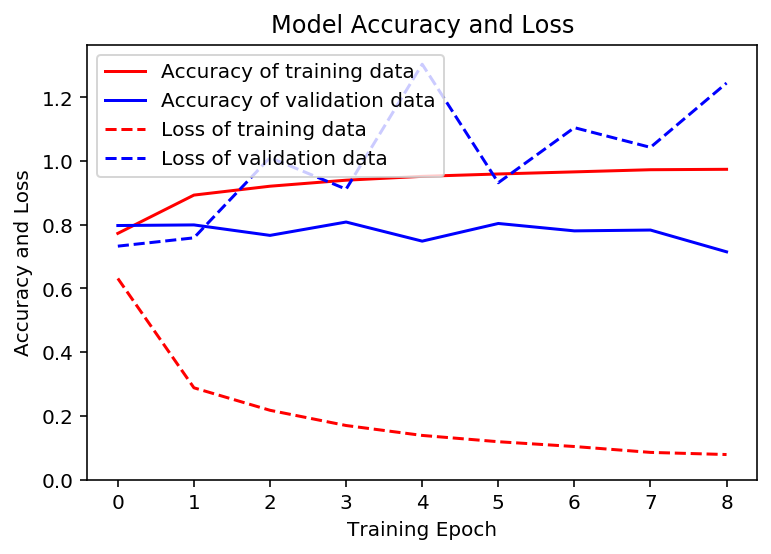

In [ ]:
show_4_graphs(history)

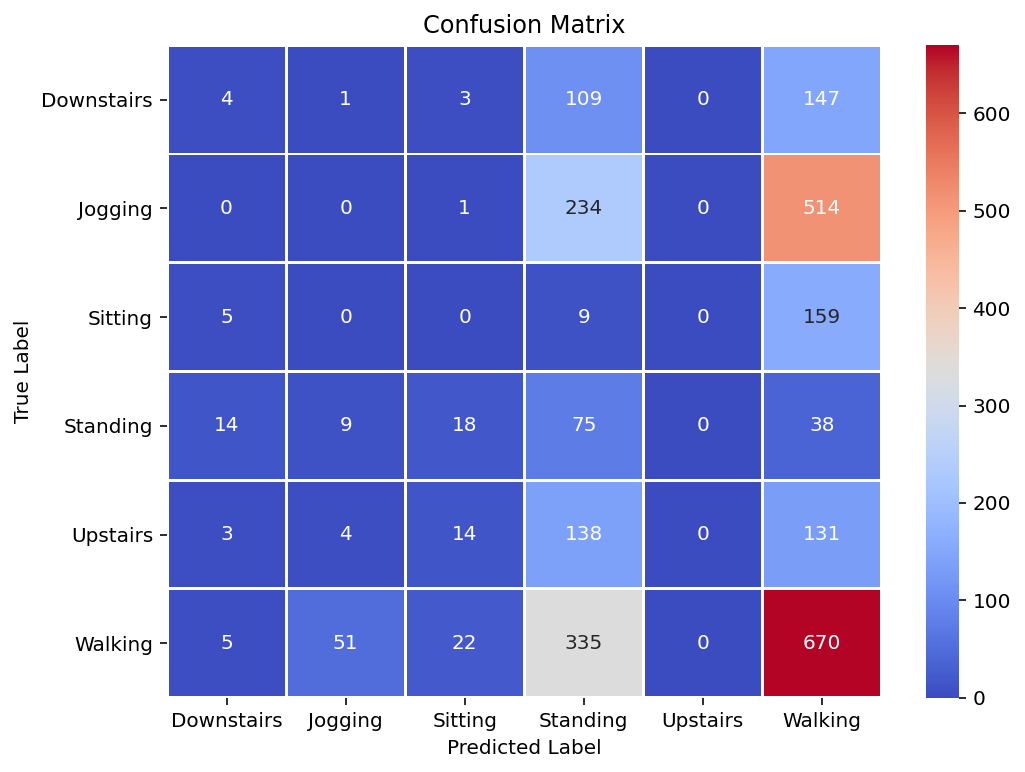

              precision    recall  f1-score   support

           0       0.13      0.02      0.03       264
           1       0.00      0.00      0.00       749
           2       0.00      0.00      0.00       173
           3       0.08      0.49      0.14       154
           4       0.00      0.00      0.00       290
           5       0.40      0.62      0.49      1083

    accuracy                           0.28      2713
   macro avg       0.10      0.19      0.11      2713
weighted avg       0.18      0.28      0.21      2713



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
import seaborn as sns
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# RNN
- 참고 사항
- 시계열 예측에는 우수하나 패턴 찾기에는 CNN이 더 우수함

In [ ]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

In [ ]:
history = model.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6201 samples, validate on 1551 samples
Epoch 1/30
6201/6201 [==============================] - 416s 67ms/step - loss: 0.7376 - accuracy: 0.7408 - val_loss: 0.8121 - val_accuracy: 0.7299
Epoch 2/30
6201/6201 [==============================] - 439s 71ms/step - loss: 0.2858 - accuracy: 0.8932 - val_loss: 0.6097 - val_accuracy: 0.7963
Epoch 3/30
6201/6201 [==============================] - 407s 66ms/step - loss: 0.5087 - accuracy: 0.8187 - val_loss: 0.6073 - val_accuracy: 0.8008
Epoch 4/30
6201/6201 [==============================] - 345s 56ms/step - loss: 0.2238 - accuracy: 0.9160 - val_loss: 0.7247 - val_accuracy: 0.7988
Epoch 5/30
6201/6201 [==============================] - 291s 47ms/step - loss: 0.1321 - accuracy: 0.9560 - val_loss: 0.6819 - val_accuracy: 0.8072
Epoch 6/30
6201/6201 [==============================] - 289s 47ms/step - loss: 0.0976 - accuracy: 0.9673 - val_loss: 0.8644 - val_accuracy: 0.7660
Epoch 7/30
6201/6201 [==============================] - 401s 65ms/step

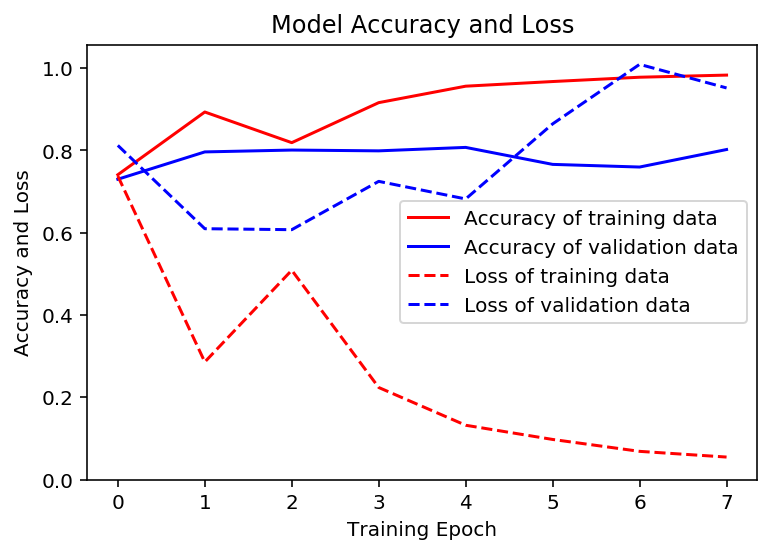

In [ ]:
show_4_graphs(history)

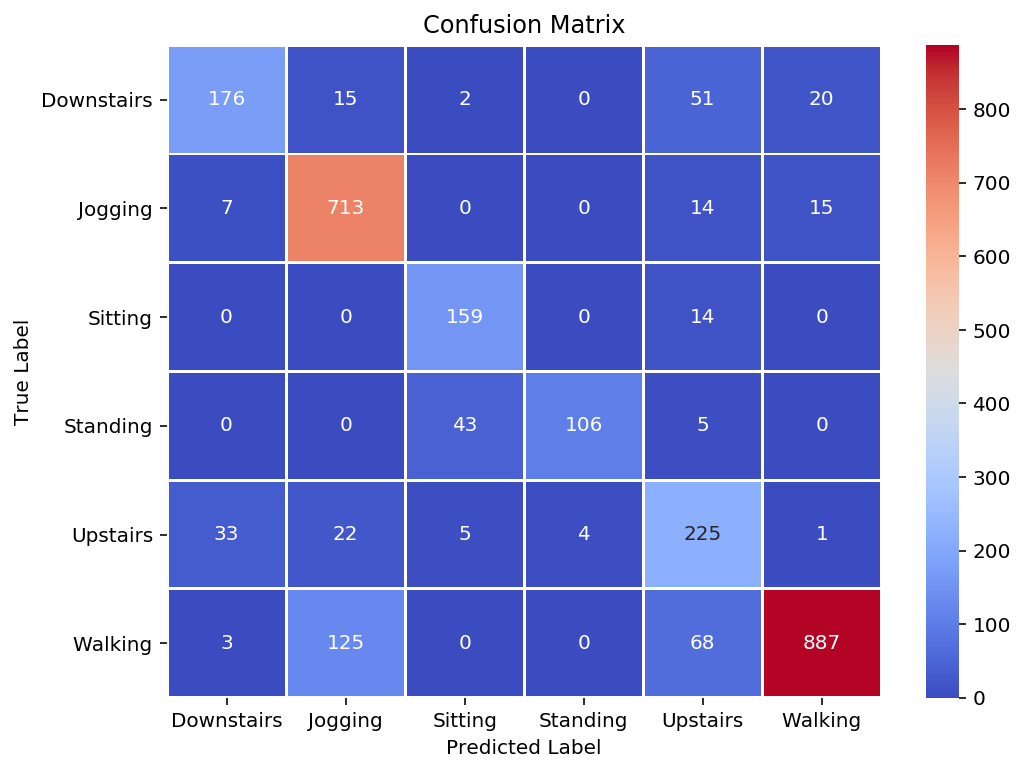

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       264
           1       0.81      0.95      0.88       749
           2       0.76      0.92      0.83       173
           3       0.96      0.69      0.80       154
           4       0.60      0.78      0.67       290
           5       0.96      0.82      0.88      1083

    accuracy                           0.84      2713
   macro avg       0.82      0.80      0.80      2713
weighted avg       0.85      0.84      0.84      2713



In [ ]:
y_pred = model.predict(X_test)
show_results(y_test, y_pred)